# 1. Load cropped

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torchvision.transforms as transforms
import math
import itertools
from torch import nn as nn
import torch.nn.functional as F
from torch import Tensor
from numpy.matlib import repmat
import torch.optim as optim
from collections import OrderedDict
import cv2
import wandb
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
# save dicts to csv
import csv


In [50]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
import random


def load_cropped(folder_path, csv_path, patient_list = [], sample_size=200, prints = False):
    # Cargar el CSV con pandas
    df = pd.read_csv(csv_path)
    
    # Convertir el CSV a un diccionario para un acceso rápido
    patient_metadata = {row['CODI']: row['DENSITAT'] for _, row in df.iterrows()}

    # Inicializar la estructura de datos para almacenar los datos de los pacientes seleccionados
    patients_data = []
    images_list = []
    patients_list_img = []

    # si no se proporciona una lista de pacientes, se seleccionan todos los pacientes iterando folder_path
    if len(patient_list) == 0:
        for patient_folder in glob.glob(os.path.join(folder_path, "*")):
            patient_id = os.path.basename(patient_folder).split("_")[0]
            patient_list.append(patient_id)
    
    incorrect_shape = 0
    # Iterar sobre cada paciente en la lista de IDs proporcionada
    for i,patient_id in enumerate(patient_list):
        # Obtener carpeta del paciente
        try:
            patient_folder = glob.glob(os.path.join(folder_path, f"{patient_id}_*"))[0]
        except:
            continue

        # Verificar que el paciente esté en el CSV
        if patient_id in patient_metadata:
            # Obtener todas las imágenes .png dentro de la carpeta del paciente
            images = glob.glob(os.path.join(patient_folder, "*.png"))
            
            # Si el paciente tiene imágenes en su carpeta
            if images:
                # Mezclar la lista de imágenes
                random.shuffle(images)
                
                if sample_size == -1:
                    sample_size = len(images)
                # Seleccionar una muestra de tamaño sample_size o menos si hay menos imágenes
                images_sampled = random.sample(images, min(sample_size, len(images)))
                
                for j,image_path in enumerate(images_sampled):
                    if j % 200 == 0:
                        if prints:
                            print(f"Processing patient {i+1}/{len(patient_list)} - image {j+1}/{len(images_sampled)}")

                    # Cargar la imagen en formato BGR con cv2
                    image_bgr = cv2.imread(image_path)
                    
                    # Convertir la imagen de BGR a RGB
                    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                    if image_rgb.shape[0] != 256 or image_rgb.shape[1] != 256:
                        incorrect_shape +=1
                        # Resize de la imagen a 256x256
                        image_rgb = cv2.resize(image_rgb, (256, 256))

                    # Permutar canales
                    image_rgb = np.transpose(image_rgb, (2, 0, 1))

                    # Pasar de uint8 a float32
                    image_rgb = image_rgb/255.0
                    
                    # Añadir la imagen a la lista de imágenes en formato RGB
                    images_list.append(image_rgb)
                # Binariar densidad
                if patient_metadata[patient_id] == "NEGATIVA":
                    dens = 0
                else:
                    dens = 1
                
                # Añadir la densidad a la lista de metadatos
                patients_data.extend([dens] * len(images_sampled))
                patients_list_img.extend([patient_id] * len(images_sampled))

    print(f'Resized images: {incorrect_shape}/{len(images_list)}')
    
    return images_list, patients_data, patients_list_img

# Paso 2: Crear la clase Standard_Dataset
class Standard_Dataset(data.Dataset):
    def __init__(self, X, Y=None, transformation=None):
        super().__init__()
        self.X = X
        self.y = Y
        self.transformation = transformation
 
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transformation:
            image = self.transformation(image)
            
        image_tensor = torch.from_numpy(image).float()
        
        if self.y is not None:
            label = torch.tensor(self.y[idx], dtype=torch.float32)
            return image_tensor, label
        else:
            return image_tensor

# Paso 3: Cargar los datos
folder_path = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Cropped"
csv_path = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/PatientDiagnosis.csv"
patient_list = []
sample_size = 1

# Filtrando imágenes y etiquetas para obtener solo aquellas cuya densidad es 0
images, labels, pat_list_img = load_cropped(folder_path, csv_path, patient_list, sample_size)

Resized images: 0/155


## 2. AUTOENCODER

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def init_weights_transformer(module,InitParams):
    Type=InitParams['Type']
    U=InitParams['U']
    
    if Type=='ori':
        init_weights_transformer_ori(module)
    elif Type=='all':
        init_weights_transformer_all(module,U)       
    else:
        init_weights_transformer_exceptnorm(module,U) 
    
def init_weights_transformer_all(module,U=[0,1]):
    param=module.state_dict()
   
    for name in param.keys():
        if name.find('norm')<0:
           nn.init.uniform_(param[name],a=U[0],b=U[1])

                
def init_weights_transformer_exceptnorm(module,U=[0,1]):
    param=module.state_dict()
   
    for name in param.keys():
        if name.find('norm')<0:
           if (name.find('weight')>0):
                nn.init.uniform_(param[name],a=U[0],b=U[1])
           elif (name.find('bias')>0):
                nn.init.constant_(param[name], 0)
    #        
def init_weights_transformer_ori(module):
    initrange = 0.1
    nn.init.uniform_(module.encoder.weight, -initrange, initrange)
    nn.init.zeros_(module.decoder1[0].bias)
    nn.init.zeros_(module.decoder2.bias)
    nn.init.uniform_(module.decoder1[0].weight, -initrange, initrange)
    nn.init.uniform_(module.decoder2.weight, -initrange, initrange)
    

def init_weights_xavier_normal(module):
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LSTM):
            for param in m.parameters():
                if len(param.shape) >= 2:
                    nn.init.orthogonal_(param.data)
                else:
                    nn.init.normal_(param.data)

def init_weights_xavier_uniform(module):
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LSTM):
            for param in m.parameters():
                if len(param.shape) >= 2:
                    nn.init.orthogonal_(param.data)
                else:
                    nn.init.uniform_(param.data)

def init_weights_kaiming_uniform(module):
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

def init_weights_kaiming_normal(module):
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

In [5]:
### Linear FC Blocks
def linear_block(n_inputs_loc, hidden_loc, 
                 activ_config=None,batch_config=None,p_drop_loc=0.1): 
    
    # Dictionary defining Block Architecture
    BlockArchitecture=[]
   
    hidden_loc.insert(0,n_inputs_loc)
  
    if activ_config==None:
        activ_config=repmat('no_activ',len(hidden_loc),1)
    if batch_config==None:
        batch_config=repmat('no_batch',len(hidden_loc),1)
    #Block Layers List
    for i in np.arange(len(hidden_loc)-1):
        BlockArchitecture.append(('linear'+str(i+1),
                                  nn.Linear(hidden_loc[i], hidden_loc[i+1])))
        
        if(activ_config[i]=='relu'):
            BlockArchitecture.append(('relu'+str(i+1),nn.ReLU(inplace=True)))
           
        elif(activ_config[i]=='tanh'):
            BlockArchitecture.append(('tanh'+str(i+1),nn.Tanh()))
        elif(activ_config[i]=='relu6'):
             BlockArchitecture.append(('relu6'+str(i+1),nn.ReLU6(inplace=True)))
             
        if(batch_config[i]=='batch'):
            BlockArchitecture.append(('batch'+str(i+1),nn.BatchNorm1d( hidden_loc[i+1])))
         
        BlockArchitecture.append(('drop'+str(i+1),nn.Dropout(p_drop_loc)))  
    linear_block_loc = nn.Sequential(
        OrderedDict(BlockArchitecture)
        )
    return linear_block_loc


class LinearBlock(nn.Module):
    """
    MultiLayer Perceptron: 
    Netwotk with n_hidden layers with architecture linear+drop+relu+batch
     Constructor Parameters:
           n_inputs: dimensionality of input features (n_channels * n_features , by default) 
                     n_channels (=14), number of sensors or images for each case
                     n_features(=40), number of features for each n_channels
           n_classes: number of output classes (=3, by default)
           hidden(=[128,128], default): list with the number of neurons for each hidden layer
           p_drop(=0.1, default): probability for Drop layer (=0, no drop is performed)

    """
    
    def __init__(self, inputmodule_params,net_params):
        super().__init__()

        
       
        ### Input Parameters
        self.n_inputs = inputmodule_params['n_inputs']

       
        self.hidden=net_params['hidden']
        self.dropout=net_params['dropout']
        if net_params['dropout'] is None:
            self.dropout=0.5
        self.nlayers=len(self.hidden)
        if 'activ_config' not in list(net_params.keys()):
    
            self.activ_config=None
        else:
             self.activ_config=net_params['activ_config']
        
        if 'batch_config' not in list(net_params.keys()):
            self.batch_config=None
        else:
            self.batch_config=net_params['batch_config']
             
              
        
        self.linear_block0= linear_block(self.n_inputs, self.hidden.copy(), 
                                                 activ_config=self.activ_config, 
                                                 batch_config=self.batch_config,
                                                 p_drop_loc=self.dropout)

       
        
      #  self.fc_out=nn.Identity()
        # weight init
        init_weights_xavier_normal(self)

    def forward(self, x):
              
      
        return self.linear_block0(x)

### Convolutional 
class _CNNLayer(nn.Module):
    def __init__(
        self, num_input_features: int, n_neurons: int, kernel_sze:int =3, 
        stride:int=1,
        drop_rate: float=0,
        Relu=True
         ) -> None:
        super().__init__()
        

        norm1 = nn.BatchNorm2d(n_neurons)
        conv1 = nn.Conv2d(num_input_features, n_neurons, kernel_size=kernel_sze,  
                               stride=stride, padding=(int((kernel_sze-1)/2)))

      #  relu1 = nn.ReLU(inplace=True)
        relu1= nn.LeakyReLU(inplace=True)

        drop=nn.Dropout(drop_rate)
        if Relu:
            self.cnn_layer=nn.Sequential(conv1,norm1,relu1,drop)
        else:
            self.cnn_layer=nn.Sequential(conv1,norm1,drop)
        init_weights_xavier_normal(self)
        
    def forward(self, x: Tensor):
         
        return(self.cnn_layer(x))

class _UnCNNLayer(nn.Module):
    def __init__(
        self, num_input_features: int, n_neurons: int, kernel_sze:int =3, 
        stride:int=2,
        drop_rate: float=0, 
        Relu=True
         ) -> None:
        super().__init__()
        
        self.stride=stride
        norm1 = nn.BatchNorm2d(n_neurons)
        conv1 = nn.ConvTranspose2d(num_input_features, n_neurons, kernel_size=kernel_sze,  
                               stride=stride, padding=(int((kernel_sze-1)/2)))

        
     #   relu1 = nn.ReLU(inplace=True)
        relu1 = nn.LeakyReLU(inplace=True)

        drop=nn.Dropout(drop_rate)
        if Relu:
            self.cnn_layer=nn.Sequential(conv1,norm1,relu1,drop)
        else:
            self.cnn_layer=nn.Sequential(conv1,norm1,drop)
        init_weights_xavier_normal(self)
        
    def forward(self, x: Tensor):
        
        if  self.stride>1:
            sze_enc=x.shape[-1]
            x=self.cnn_layer[0](x,output_size=(sze_enc*2,sze_enc*2))
            for k in np.arange(1,len(self.cnn_layer)):
                x=self.cnn_layer[k](x)
        else:
            x=self.cnn_layer(x)
            
        return(x)
    
    # def forward(self, x1, x2):
    #     x1 = self.cnn_layer(x1)
    #     # input is CHW
    #     diffY = x2.size()[2] - x1.size()[2]
    #     diffX = x2.size()[3] - x1.size()[3]

    #     x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
    #                     diffY // 2, diffY - diffY // 2])
    #     # if you have padding issues, see
    #     # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    #     # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    #     x = torch.cat([x2, x1], dim=1)
    #     return self.conv(x)
    
class _CNNBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_input_channels: int=1,
        drop_rate=0,
        block_config = (64,128),
        stride=None,
        decoder=False,
        Relu=True
    
    ) -> None:
        super().__init__()
        
        num_layers=len(block_config)
        self.num_input_channels=num_input_channels
        print('block inp ch',num_input_channels)
        
        if stride is None:
            stride=np.ones(num_layers)
            
        for i in range(num_layers):
            if decoder==True:
                layer = _UnCNNLayer(
                    num_input_channels,
                    n_neurons=block_config[i],
                    stride=stride[i],
                    drop_rate=drop_rate
                    
                )
            else:
                layer = _CNNLayer(
                    num_input_channels,
                    n_neurons=block_config[i],
                    stride=stride[i],
                    drop_rate=drop_rate, 
                    Relu=Relu
                    
                )
            self.add_module("cnnlayer%d" % (i + 1), layer)
            num_input_channels=block_config[i]

    def forward(self, x: Tensor) -> Tensor:
        
        for name, layer in self.items():
            x = layer(x)
            
            
        return x



In [6]:

#  BACKBONE MODULES 
class Encoder(nn.Module):
    r"""Encoder class
    `".
    Input Parameters:
        1. inputmodule_params: dictionary with keys ['num_input_channels']
            inputmodule_params['num_input_channels']=Channels of input images
        2. net_params: dictionary defining architecture: 
            net_params['block_configs']: list of number of neurons for each 
            convolutional block. A block can have more than one layer
            net_params['stride']:list of strides for each block layers
            net_params['drop_rate']: value of the Dropout (equal for all blocks)
        Examples: 
            1. Encoder with 4 blocks with one layer each
            net_params['block_configs']=[[32],[64],[128],[256]]
            net_params['stride']=[[2],[2],[2],[2]]
            2. Encoder with 2 blocks with two layers each
            net_params['block_configs']=[[32,32],[64,64]]
            net_params['stride']=[[1,2],[1,2]]
            
    """

    def __init__(self, inputmodule_params,net_params):
        super().__init__()
        
        
        num_input_channels=inputmodule_params['num_input_channels']
        

            
        drop_rate=net_params['drop_rate']
        block_configs=net_params['block_configs'].copy()
        n_blocks=len(block_configs)
        if 'stride' in net_params.keys():
            stride=net_params['stride']
        else:
            stride=[]
            for i in np.arange(len(block_configs)):
                stride.append(list(np.ones(len(block_configs[i])-1,dtype=int))+[2])
                
        # Encoder
        self.encoder=nn.Sequential(          
            )
        outchannels_encoder=[]
        for i in np.arange(n_blocks):
            print('block',i)
            block = _CNNBlock(
                num_input_channels=num_input_channels,
                drop_rate=drop_rate,
                block_config=block_configs[i],
                stride= stride[i]               
                
            )
            self.encoder.add_module("cnnblock%d" % (i + 1), block)
            
            if stride==1:
                self.encoder.add_module("mxpool%d" % (i + 1), 
                                         nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

            num_input_channels=block_configs[i][-1] 
           # outchannels_encoder.append(num_input_channels)
           
          
               
    def forward(self, x: Tensor) -> Tensor:
        
        x=self.encoder(x)

        return x

class Decoder(nn.Module):
    r"""Decoder class
    `".
    Input Parameters:
        1. inputmodule_params: dictionary with keys ['num_input_channels']
            inputmodule_params['num_input_channels']=Channels of input images
        2. net_params: dictionary defining architecture: 
            net_params['block_configs']: list of number of neurons for each conv block
            net_params['stride']:list of strides for each block layers
            net_params['drop_rate']: value of the Dropout (equal for all blocks)
    """
    def __init__(self, inputmodule_params,net_params):
        super().__init__()
        
   
        num_input_channels=inputmodule_params['num_input_channels']
        
        self.upPoolMode='bilinear'

            
        drop_rate=net_params['drop_rate']
        block_configs=net_params['block_configs'].copy()
        self.n_blocks=len(block_configs)
        
        if 'stride' in net_params.keys():
            stride=net_params['stride']
        else:
            stride=[]
            for i in np.arange(len(block_configs)):
                stride.append(list(np.ones(len(block_configs[i])-1,dtype=int))+[2])
                

        # Decoder
        self.decoder=nn.Sequential(          
            )
        
        for i0 in np.arange(self.n_blocks)[::-1]:
            i=self.n_blocks-(i0+1)
            block = _CNNBlock(
                num_input_channels=num_input_channels,
                drop_rate=drop_rate,
                block_config=block_configs[i], 
                stride=stride[i],
                decoder=True
            )
            
            # if stride==1:
            #     self.decoder.add_module("uppool%d" % (i + 1), 
            #                               nn.Upsample(scale_factor=2, 
            #                                           mode=self.upPoolMode, align_corners=True))
            
            self.decoder.add_module("cnnblock%d" % (i0+1), block)
      

            num_input_channels=block_configs[i][-1]
        
        
        self.decoder[-1][list(self.decoder[-1].keys())[-1]].cnn_layer[2]=nn.Identity()
        
    def forward(self, x: Tensor) -> Tensor:
        
        input_sze=x.shape

     #   for i in np.arange(n_blocks)[::-1]:
            
        x=self.decoder(x)
    
        return x

##### GENERATIVE MODELS 
class AutoEncoderCNN(nn.Module):
    r"""AutoEncoderCNN model class
    `".
    Input Parameters:
        1. inputmodule_paramsEnc: dictionary with keys ['num_input_channels']
            inputmodule_paramsEnc['num_input_channels']=Channels of input images
        2. net_paramsEnc: dictionary defining architecture of the Encoder (see Encoder class) 
        3. inputmodule_paramsDec: dictionary with keys ['num_input_channels']
           inputmodule_paramsDec['num_input_channels']=Channels of input images
        4. net_paramsDec: dictionary defining architecture of the Encoder (see Decoder/Encoder classes) 
    """

    def __init__(self, inputmodule_paramsEnc,net_paramsEnc,inputmodule_paramsDec,net_paramsDec):
        super().__init__()
 
        self.inputmodule_paramsEnc=inputmodule_paramsEnc
        self.inputmodule_paramsDec=inputmodule_paramsDec
        self.net_paramsEnc=net_paramsEnc
        self.net_paramsDec=net_paramsDec

        # Encoder
        self.encoder=Encoder(inputmodule_paramsEnc,net_paramsEnc)
     
        # Decoder
        self.decoder=Decoder(inputmodule_paramsDec,net_paramsDec)
        
    def forward(self, x: Tensor) -> Tensor:
            # Guardamos el tamaño de la imagen de entrada para usarlo al final (en la fase de upsampling)
            input_size = x.shape

            # Paso por el Encoder
            encoded = self.encoder(x)
            
            # Paso por el Decoder
            decoded = self.decoder(encoded)
            
            return decoded


## 3. TRAIN

In [7]:
# Filtrando imágenes y etiquetas para obtener solo aquellas cuya densidad es 0
images, labels = load_cropped(folder_path, csv_path, patient_list, sample_size)
filtered_images = [img for img, label in zip(images, labels) if label == 0]
filtered_labels = [label for label in labels if label == 0]

# Crear el Dataset y DataLoader solo con las imágenes de densidad 0
filtered_dataset_train = Standard_Dataset(filtered_images)
dataloader_train = DataLoader(filtered_dataset_train, batch_size=32, shuffle=True)

Resized images: 0/155


In [8]:
def AEConfigs(Config):
    
    if Config=='1':
        # CONFIG1
        net_paramsEnc['block_configs']=[[32,32],[64,64]]
        net_paramsEnc['stride']=[[1,2],[1,2]]
        net_paramsEnc['drop_rate']=0.1
        net_paramsDec['drop_rate']=0.1
        net_paramsDec['block_configs']=[[64,32],[32,inputmodule_paramsEnc['num_input_channels']]]
        net_paramsDec['stride']=net_paramsEnc['stride']
        inputmodule_paramsDec['num_input_channels']=net_paramsEnc['block_configs'][-1][-1]
     

        
    elif Config=='2':
        # CONFIG 2
        net_paramsEnc['block_configs']=[[32],[64],[128],[256]]
        net_paramsEnc['stride']=[[2],[2],[2],[2]]
        net_paramsDec['block_configs']=[[128],[64],[32],[inputmodule_paramsEnc['num_input_channels']]]
        net_paramsDec['stride']=net_paramsEnc['stride']
        inputmodule_paramsDec['num_input_channels']=net_paramsEnc['block_configs'][-1][-1]
   
        
    elif Config=='3':  
        # CONFIG3
        net_paramsEnc['block_configs']=[[32],[64],[64]]
        net_paramsEnc['stride']=[[1],[2],[2]]
        net_paramsDec['block_configs']=[[64],[32],[inputmodule_paramsEnc['num_input_channels']]]
        net_paramsDec['stride']=net_paramsEnc['stride']
        inputmodule_paramsDec['num_input_channels']=net_paramsEnc['block_configs'][-1][-1]
    
    return net_paramsEnc,net_paramsDec,inputmodule_paramsDec


######################### 0. EXPERIMENT PARAMETERS

# 0.2 Parámetros y definiciones de red
inputmodule_paramsEnc = {'num_input_channels': 3}
net_paramsEnc = {}
net_paramsDec = {}
inputmodule_paramsDec = {}

# 0.1 AE PARAMETERS
inputmodule_paramsEnc={}
inputmodule_paramsEnc['num_input_channels']=3

###### CONFIG1
Config='1'
net_paramsEnc,net_paramsDec,inputmodule_paramsDec=AEConfigs(Config)
model=AutoEncoderCNN(inputmodule_paramsEnc, net_paramsEnc,
                     inputmodule_paramsDec, net_paramsDec)

block 0
block inp ch 3
block 1
block inp ch 32
block inp ch 64
block inp ch 32


In [8]:

# import torch
# import torch.optim as optim
# import torch.nn.functional as F
# from tqdm import tqdm

# # Hiperparámetros del entrenamiento
# num_epochs = 10  # Número de épocas de entrenamiento
# learning_rate = 0.001  # Tasa de aprendizaje

# # Definir el optimizador (en este caso, Adam)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Definir la función de pérdida (MSE)
# criterion = nn.MSELoss()

# # Enviar el modelo a la GPU si está disponible
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Bucle de entrenamiento
# for epoch in range(num_epochs):
#     model.train()  # Poner el modelo en modo de entrenamiento
#     running_loss = 0.0  # Para almacenar la pérdida de cada época

#     # Iterar sobre el dataloader
#     for batch_idx, images in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs}")):
#         # Enviar los datos a la GPU si está disponible
#         images=images.permute(0,3,1,2) # permute images
#         images = images.to(device)
        
#         # Inicializar el gradiente a cero
#         optimizer.zero_grad()
        
#         # Paso forward
#         outputs = model(images)
        
#         # Calcular la pérdida
#         loss = criterion(outputs, images)
        
#         # Paso backward (retropropagación)
#         loss.backward()
        
#         # Actualizar los pesos
#         optimizer.step()
        
#         # Acumular la pérdida
#         running_loss += loss.item()
    
#     # Imprimir la pérdida promedio de cada época
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader_train)}")

In [25]:
!pip install wandb


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install wandb


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import wandb

# Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

# Inicia sesión en Weights & Biases y configura el experimento
wandb.init(
    project="repte3",    # Reemplaza con el nombre de tu proyecto
    entity="andreu-mir",      # Nombre del equipo
    name="test",    # Opcional: nombre específico para esta ejecución
    config={                          # Diccionario de configuraciones personalizadas
        "learning_rate": 0.01,
        "batch_size": 32,
        "num_epochs": 45,
        "model_architecture": "AutoEncoderCNN",
        "optimizer": "Adam"
    }
)

# Accede a los parámetros configurados como un diccionario
config = wandb.config
print("Learning rate configurado:", config.learning_rate)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\mirvi\.netrc


Learning rate configurado: 0.01


In [10]:
wandb.finish()

In [12]:
for batch_idx, images in enumerate(dataloader_train):
    print(images.shape)  # Añadir esta línea para ver la forma de las imágenes
    break


torch.Size([32, 3, 256, 256])


## 4. FRED THRESHOD

In [9]:
# load model
model = AutoEncoderCNN(inputmodule_paramsEnc, net_paramsEnc,
                     inputmodule_paramsDec, net_paramsDec)
model.load_state_dict(torch.load('C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/AutoEncoder/Best_Models/best_model_AECNN3_50.pth'))

block 0
block inp ch 3
block 1
block inp ch 32
block inp ch 64
block inp ch 32


C:\Users\mirvi\AppData\Local\Temp\ipykernel_10144\3983117907.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/mirvi/Desktop/mii

<All keys matched successfully>

### 4.1 Visualitzem outputs

Imatge SENSE HELICOBACTER


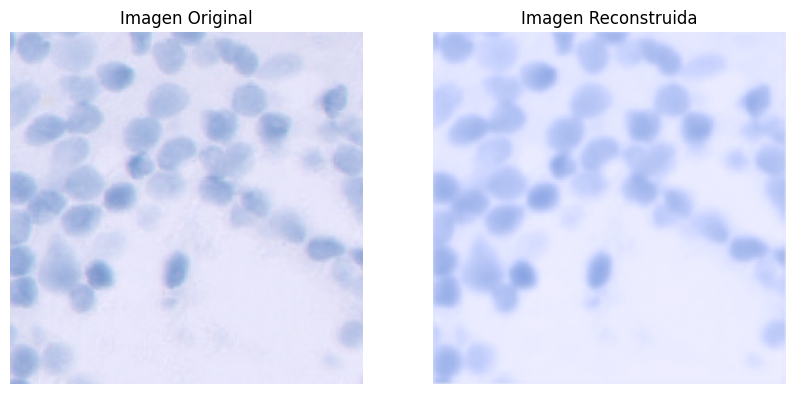

Imatge AMB HELICOBACTER


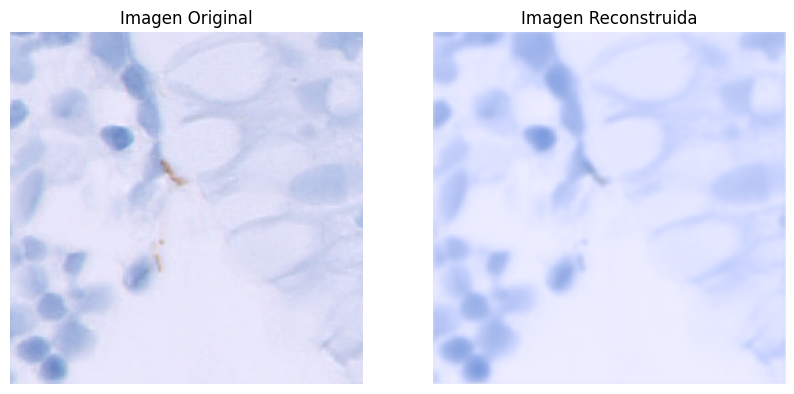

In [10]:
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

def visualize_images(image, model, totensor = True):
    if totensor:
        transform = transforms.ToTensor()
        image_tensor = transform(image).unsqueeze(0)  # Añadir dimensión de batch

    # Pasar la imagen por el modelo
    with torch.no_grad():
        # normalizar pixeles
        reconstructed = model(image_tensor)

    # Reescalar la imagen para visualizarla
    reconstructed = reconstructed.squeeze(0)  # Eliminar dimensión de batch
    reconstructed = reconstructed.permute(1, 2, 0)  # Permutar canales

    # numpy to PIL
    reconstructed_PIL = Image.fromarray((reconstructed.numpy() * 255).astype(np.uint8))

    # Adjust both brightness and contrast for a balanced enhancement
    contrast_enhancer = ImageEnhance.Contrast(reconstructed_PIL)
    image_with_contrast = contrast_enhancer.enhance(1.4)  # Moderate contrast increase

    brightness_enhancer = ImageEnhance.Brightness(image_with_contrast)
    final_adjusted_image = brightness_enhancer.enhance(1.5)  # Moderate brightness increase

    # PIL to numpy
    reconstructed = np.array(final_adjusted_image)

    # Visualizar las imágenes
    plt.figure(figsize=(10, 5))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Imagen Original")
    plt.axis("off")

    # Imagen reconstruida
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed)
    plt.title("Imagen Reconstruida")
    plt.axis("off")

    plt.show()

# Configurar el modelo en modo de evaluación
model.eval()

# B22-45	0	1,027	6,610	7,783	256	256	1
# B22-45	0	1,050	5,589	12,144	256	256	-1

# SENSE PRESENCIA
image_path_neg = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Annotated/B22-45_0/01050.png"

# AMB PRESENCIA
image_path_pos = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Annotated/B22-45_0/01027.png"

image_n = cv2.imread(image_path_neg)
image_n = cv2.cvtColor(image_n, cv2.COLOR_BGR2RGB)

image_p = cv2.imread(image_path_pos)
image_p = cv2.cvtColor(image_p, cv2.COLOR_BGR2RGB) 

# Visualizar la imagen original y la imagen reconstruida
print('Imatge SENSE HELICOBACTER')
visualize_images(image_n, model)
print('Imatge AMB HELICOBACTER')
visualize_images(image_p, model)

In [19]:
# Permutar canales
image_np = np.transpose(image_p, (2, 0, 1))

# Pasar de uint8 a float32
image_np = image_np/255.0

# Convertir a tensor
image = torch.from_numpy(image_np).float().unsqueeze(0)

model.eval()
with torch.no_grad():
    reconstructed = model(image)

# permute HWC
image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Convertir a formato HUE (HSV)
hsv_orig = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hsv_rec = cv2.cvtColor(reconstructed, cv2.COLOR_RGB2HSV)

# Calcular F_red para la imagen original y la reconstrucción
h_orig = hsv_orig[:, :, 0]
h_rec = hsv_rec[:, :, 0]

mask_orig = ((h_orig >= 160) & (h_orig <= 179)) | (h_orig >= 0) & (h_orig <= 20)
mask_rec = ((h_rec >= 160) & (h_rec <= 179)) | (h_rec >= 0) & (h_rec <= 20)

fred = np.sum(mask_orig) / max(np.sum(mask_rec), 1)

print(f'F_red: {fred}')

F_red: 50.0


In [19]:
th = 25

# pos: imatges positives (amb bacteria)
pos = 50 >= 25
print(pos)

positives = [False, True, True, False, True] # 2 neg / 3 pos
total = len(positives)

ratio_pos = sum(positives) / total
print(ratio_pos)

patient_ratios = np.array([0.4,0.5,0.8,0.7,0.9])

th = 0.5
patient_diag = patient_ratios > th
print(patient_diag)

True
0.6
[False False  True  True  True]


In [154]:
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Cargar las etiquetas de presencia de pacientes
patient_presence_labels = np.array([-1, -1, 1, -1, -1, 1])
patient_positive_counts = np.array([0.68, 0.73, 0.33, 0, 5, 6])

# Calcular la curva ROC
fpr, tpr, roc_thresholds = roc_curve(patient_presence_labels, patient_positive_counts)
auc = roc_auc_score(patient_presence_labels, patient_positive_counts)

# Encontrar el threshold más cercano a (1,1) en TPR y FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = roc_thresholds[optimal_idx]

### 4.2 Load Annotated

In [11]:
from torchvision import transforms
import torch
import numpy as np
from PIL import Image
from torch.utils import data

class Standard_Dataset(data.Dataset):
    def __init__(self, X, Y=None, transformation=None):
        super().__init__()
        self.X = X
        self.y = Y
        self.transformation = transformation

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]

        if self.transformation:

            # Convertir la imagen de numpy a PIL
            image = Image.fromarray(image.astype(np.uint8))

            # Aplicar la transformación (resize, etc.)
            image = self.transformation(image)

            # Convertir la imagen transformada de PIL a numpy
            image = np.array(image)
            
            # Normalizar la imagen (a valores de [0, 1])
            image = image / 255.0
        
        if self.y is not None:
            return torch.from_numpy(image).float(), torch.from_numpy(np.array(self.y[idx]))
        else:
            return torch.from_numpy(image).float()



In [12]:
# stablish seed random
random.seed(63)

# Función para cargar imágenes y sus rutas desde carpetas de pacientes específicos
def load_annotated(folder_path, excel_path, sample_size=200, patient_list=None):

    # Leer el archivo Excel y cargar las columnas especificadas
    df = pd.read_excel(excel_path, usecols=["Pat_ID", "Window_ID", "Presence"])
    
    images_list = []
    presence_labels = []
    patient_image_list = []
    images_windows = []
    
    # Iterar solo sobre las carpetas de pacientes en patient_list
    for patient_id in patient_list:
        # Encontrar subcarpetas que correspondan al paciente
        patient_folders = glob.glob(os.path.join(folder_path, f"{patient_id}_*"))

        for subfolder in patient_folders:
            if os.path.isdir(subfolder):  
                images = glob.glob(os.path.join(subfolder, "*.png"))

                # Obtener los metadatos del paciente
                df_patient = df[df['Pat_ID'] == patient_id]
                
                if images:
                    random.shuffle(images)
                    if sample_size > 0:
                        images_sampled = random.sample(images, min(sample_size, len(images)))
                    else:
                        images_sampled = random.sample(images, len(images))
                    
                    for image_path in images_sampled:
                        # Cargar la imagen
                        image = cv2.imread(image_path)

                        # Convertir de BGR a RGB
                        image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                        # Resize si es necesario
                        if image_np.shape[0] != 256 or image_np.shape[1] != 256:
                            image_np = cv2.resize(image_np, (256, 256))

                        # Permutar canales
                        image_np = np.transpose(image_np, (2, 0, 1))

                        # Pasar de uint8 a float32
                        image_np = image_np / 255.0
                        
                        # Obtener el ID de ventana y la etiqueta de presencia
                        image_name = str(os.path.splitext(os.path.basename(image_path))[0])
                        if image_name != '00000':
                            window_id = image_name.lstrip("0")  # Eliminar ceros a la izquierda
                        else:
                            window_id = "0"

                        if "Aug" not in window_id:
                            window_id = int(window_id)
                        pres = df_patient[df_patient['Window_ID'] == window_id]["Presence"].values
                        # Nomes els que tenen presencia
                        if pres.size > 0:
                            presence = pres[0]
                            presence_labels.append(presence)
                            patient_image_list.append(patient_id)
                            images_windows.append(image_name) 
                            images_list.append(image_np)

    return images_list, presence_labels, patient_image_list, images_windows

def split_patients(n_groups, path):
    # Leer el archivo Excel y cargar las columnas especificadas
    df = pd.read_excel(path, usecols=["Pat_ID", "Window_ID", "Presence"])
    patients = df["Pat_ID"].unique()
    random.shuffle(patients)
    patients_groups = np.array_split(patients, n_groups)
    return patients_groups


# Cargar los datos
folder_path = 'C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Annotated'
excel_path = 'C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/HP_WSI-CoordAllAnnotatedPatches.xlsx'
sample_size = -1

# Split data
patient_list = split_patients(10, excel_path)[0]
print(patient_list)

# Load images to dataloader
images, presence_labels,patient_image_list, images_windows = load_annotated(folder_path, excel_path, sample_size, patient_list)
dataset_annotated = Standard_Dataset(images)
dataloader_annotated = DataLoader(dataset_annotated, batch_size=1, shuffle=False)

['B22-214' 'B22-173' 'B22-299' 'B22-210' 'B22-94' 'B22-124' 'B22-254'
 'B22-250' 'B22-313' 'B22-111' 'B22-117' 'B22-186' 'B22-123' 'B22-304'
 'B22-270' 'B22-50']


In [371]:
print(len(presence_labels))
print(len(images))

582
582


In [90]:
for i,image in enumerate(dataloader_annotated):
    img = image[0].permute(1, 2, 0).cpu().numpy()
    print(presence_labels[i])
    print(patient_image_list[i])
    print(images_windows[i])
    print()
    break  


-1
B22-214
00949



In [126]:
df = pd.read_excel(excel_path, usecols=["Pat_ID", "Window_ID", "Presence"])
print(df[df['Pat_ID']=='B22-214'])

      Pat_ID Window_ID  Presence
289  B22-214       949        -1
290  B22-214      1101        -1


### 4.3 Patient Diagnosis Threshold

In [30]:
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc

def get_fred(model, dataloader,device):
    model.eval()  # Cambiar el modelo a modo evaluación
    fred_values = []  # Almacenar los valores de F_red

    if device == 'cuda' and torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    j=0

    with torch.no_grad():
        for i,images in enumerate(dataloader):
            if type(images) == list:
                # images to tensor
                image = images[0]
                image = image.to(device)
                image = image/255.0
            else:
                # Enviar imágenes al dispositivo
                images = images.to(device)
                image = images/255.0
            
            # Obtener las reconstrucciones del modelo
            reconstructed = model(image)
            
            # permute HWC
            image = image[0]
            image = image.permute(1, 2, 0).cpu().numpy()
            reconstructed = reconstructed[0]
            reconstructed = reconstructed.permute(1, 2, 0).cpu().numpy()

            # Convertir a formato HUE (HSV)
            hsv_orig = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            hsv_rec = cv2.cvtColor(reconstructed, cv2.COLOR_RGB2HSV)
            
            # Calcular F_red para la imagen original y la reconstrucción
            h_orig = hsv_orig[:, :, 0]
            h_rec = hsv_rec[:, :, 0]

            mask_orig = ((h_orig >= 160) & (h_orig <= 179)) | (h_orig >= 0) & (h_orig <= 20)
            mask_rec = ((h_rec >= 160) & (h_rec <= 179)) | (h_rec >= 0) & (h_rec <= 20)

            fred = np.sum(mask_orig) / max(np.sum(mask_rec), 1)

            # Almacenar valores y etiquetas reales
            fred_values.append(fred)
   
    return fred_values

# Calcular F_red para las imágenes de densidad 0
fred_values = get_fred(model, dataloader_annotated, device="cpu")
print('len fred',len(fred_values))

len fred 582


582
582


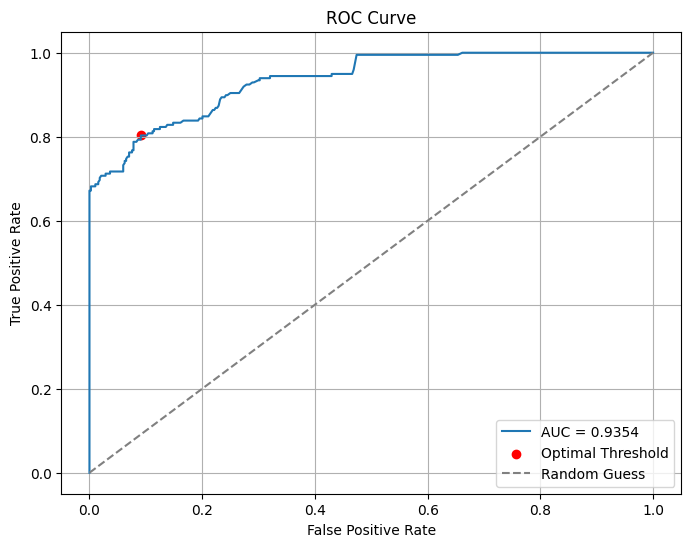

Optimal Threshold: 256.0
AUC: 0.9354


In [31]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def find_FRED_threshold(fred_values, presence_labels, visualize = True):
    # Generar umbrales aleatorios dentro del rango de fred_values
    optimal_threshold = None

    # Calcular la curva ROC
    fpr, tpr, roc_thresholds = roc_curve(presence_labels, fred_values)
    auc = roc_auc_score(presence_labels, fred_values)

    # Encontrar el threshold más cercano a (1,1) en TPR y FPR
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = roc_thresholds[optimal_idx]

    # Visualización de la curva ROC
    if visualize:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label="Optimal Threshold")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid()
        plt.show()

    return optimal_threshold, auc, fpr, tpr, roc_thresholds

# Ejemplo de uso:
print(len(fred_values))
print(len(presence_labels))
optimal_threshold, auc, fpr, tpr, thresholds = find_FRED_threshold(fred_values, presence_labels)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"AUC: {auc:.4f}")


In [13]:
folder_path = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Cropped"
csv_path = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/PatientDiagnosis.csv"

images, labels_patient = load_cropped(folder_path, csv_path, patient_list, -1)

KeyboardInterrupt: 

In [387]:
print(len(patient_list))

16


In [14]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def find_PATIENT_threshold(fred_values, patient_image_list, patient_labels, image_threshold):
    # Clasificar imágenes como positivas o negativas según el threshold del fred
    image_positive = np.array(fred_values) >= image_threshold
    unique_patients = np.unique(patient_image_list)
    patient_positive_counts = []
    patient_presence_labels = []
    # Obtenemos el número de imágenes clasificadas como positivas por cada paciente
    for patient_id in unique_patients:
        # Extraer imágenes de este paciente
        patient_indices = np.where(np.array(patient_image_list) == patient_id)[0]
        # Contar imágenes positivas para este paciente
        patient_positive_counts.append(np.sum(image_positive[patient_indices]) / len(patient_indices))
        # Obtener label de presencia para este paciente
        patient_presence_label = patient_labels[patient_indices[0]]
        patient_presence_labels.append(patient_presence_label)

    # Calcular la curva ROC
    fpr, tpr, roc_thresholds = roc_curve(patient_presence_labels, patient_positive_counts)
    
    # Calcular el AUC
    auc = roc_auc_score(patient_presence_labels, patient_positive_counts)

    # Encontrar el threshold más cercano a (1,1) en TPR y FPR
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = roc_thresholds[optimal_idx]

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve for Patient-Level Classification")
    plt.legend()
    plt.grid()
    plt.show()

    return int(optimal_threshold), auc

# Llamar a la función con los datos
optimal_threshold, auc = find_PATIENT_threshold(fred_values, patient_image_list, labels_patient, optimal_threshold)

# el error es pq estic carregant tots els patients a cropped i menus a anotated

NameError: name 'fred_values' is not defined

## 5. KFOLD EVALUATION

### 5.1 Create dataloaders

In [45]:
# load annotated data
def create_annotated_dataloader(train_patients, folder_path, excel_path, sample_size=-1):
    # Load data
    images_train, presence_labels_train, patient_image_list_train, images_windows_train = load_annotated(folder_path, excel_path, sample_size, train_patients)

    # Create dataset
    dataset_train = Standard_Dataset(images_train, presence_labels_train)

    # Create dataloader
    dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)


    return dataloader_train, presence_labels_train, patient_image_list_train, images_windows_train

# load cropped data
def create_cropped_dataloader(val_patients, folder_path, csv_path, sample_size=-1, prints = False, shuffle=False):
    # Load data
    images_val, patient_labels, pat_img_list = load_cropped(folder_path, csv_path, val_patients, sample_size, prints)

    # Create dataset
    dataset_val = Standard_Dataset(images_val, patient_labels)

    # Create dataloader
    dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=shuffle)

    return dataloader_val, patient_labels, pat_img_list

### 5.2 Obtain FRED values

In [16]:
def get_fred(model, dataloader,device):
    model.eval()  # Cambiar el modelo a modo evaluación
    fred_values = []  # Almacenar los valores de F_red

    if device == 'cuda' and torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    j=0

    with torch.no_grad():
        for i,images in enumerate(dataloader):
            if type(images) == list:
                # images to tensor
                image = images[0]
                image = image.to(device)
                image = image/255.0
            else:
                # Enviar imágenes al dispositivo
                images = images.to(device)
                images = images/255.0
                image = images[0]
            
            # Obtener las reconstrucciones del modelo
            reconstructed = model(image)
            
            # permute HWC
            image = image[0]
            image = image.permute(1, 2, 0).cpu().numpy()
            reconstructed = reconstructed[0]
            reconstructed = reconstructed.permute(1, 2, 0).cpu().numpy()

            # Convertir a formato HUE (HSV)
            hsv_orig = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            hsv_rec = cv2.cvtColor(reconstructed, cv2.COLOR_RGB2HSV)
            
            # Calcular F_red para la imagen original y la reconstrucción
            h_orig = hsv_orig[:, :, 0]
            h_rec = hsv_rec[:, :, 0]

            mask_orig = ((h_orig >= 160) & (h_orig <= 179)) | (h_orig >= 0) & (h_orig <= 20)
            mask_rec = ((h_rec >= 160) & (h_rec <= 179)) | (h_rec >= 0) & (h_rec <= 20)

            fred = np.sum(mask_orig) / max(np.sum(mask_rec), 1)

            # Almacenar valores y etiquetas reales
            fred_values.append(fred)
   
    return fred_values


### 5.2 Find patch (fred) threshold


In [17]:
def find_FRED_threshold(fred_values, presence_labels, visualize = True):
    # Generar umbrales aleatorios dentro del rango de fred_values
    optimal_threshold = None

    # Calcular la curva ROC
    fpr, tpr, roc_thresholds = roc_curve(presence_labels, fred_values)
    auc = roc_auc_score(presence_labels, fred_values)

    # Encontrar el threshold más cercano a (1,1) en TPR y FPR
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = roc_thresholds[optimal_idx]

    # Visualización de la curva ROC
    if visualize:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label="Optimal Threshold")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid()
        plt.show()

    return int(optimal_threshold), auc, fpr, tpr, roc_thresholds

### 5.3 Find patient threshold

In [53]:
def find_PATIENT_threshold(fred_values, patient_image_list, patient_labels, image_threshold, visualize = True):
    # Clasificar imágenes como positivas o negativas según el threshold del fred
    image_positive = np.array(fred_values) >= image_threshold
    unique_patients = np.unique(patient_image_list)
    patient_positive_counts = []

    # Obtenemos el número de imágenes clasificadas como positivas por cada paciente
    for patient_id in unique_patients:
        # Extraer imágenes de este paciente
        patient_indices = np.where(np.array(patient_image_list) == patient_id)[0]
        # Contar imágenes positivas para este paciente
        patient_positive_counts.append(np.sum(image_positive[patient_indices])/len(patient_indices))

    # Calcular la curva ROC
    fpr, tpr, roc_thresholds = roc_curve(patient_labels, patient_positive_counts)
    
    # Calcular el AUC
    try:
        auc = roc_auc_score(patient_labels, patient_positive_counts)
    except:
        print('error')
        auc = 0.0000

    # Encontrar el threshold más cercano a (1,1) en TPR y FPR
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = roc_thresholds[optimal_idx]

    # Graficar la curva ROC
    if visualize:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title("ROC Curve for Patient-Level Classification")
        plt.legend()
        plt.grid()
        plt.show()

    return optimal_threshold, auc


### 5.4 Evaluate patient with thresholds

In [65]:
def classify_FRED_threshold(fred_values, patch_threshold_fred):
    img_positive = np.array(fred_values) >= patch_threshold_fred
    return img_positive 

def classify_PATIENT_threshold(fred_values, patient_val, patient_image_list, patch_threshold_fred, patient_threshold_fred):
    # Clasificar imágenes como positivas o negativas según el threshold del fred
    img_positive = classify_FRED_threshold(fred_values, patch_threshold_fred)
    unique_patients = np.unique(patient_val)
    patient_positive_counts = []

    # Obtenemos el número de imágenes clasificadas como positivas por cada paciente
    for patient_id in unique_patients:
        # Extraer imágenes de este paciente
        patient_indices = np.where(np.array(patient_image_list) == patient_id)[0]
        # Contar imágenes positivas para este paciente
        patient_positive_counts.append(np.sum(img_positive[patient_indices]) / len(patient_indices))

    # Clasificar pacientes como positivos o negativos según el threshold del fred
    patient_positive = np.array(patient_positive_counts) >= patient_threshold_fred

    return patient_positive

### 5.5 Obtain Metrics

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification(y_true, y_pred, fold_idx=None, save_path=None):
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    tn, fp, fn, tp = cm.ravel()

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)

    # Imprimir métricas
    print(f"Fold {fold_idx} - Evaluation Metrics" if fold_idx is not None else "Evaluation Metrics")
    print(f"Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Guardar la matriz de confusión como una imagen si `save_path` está definido
    if save_path:
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix - Fold {fold_idx}" if fold_idx is not None else "Confusion Matrix")
        plt.tight_layout()

        # Generar el nombre del archivo
        filename = f"confusion_matrix_fold_{fold_idx}.png" if fold_idx is not None else "confusion_matrix.png"
        plt.savefig(f"{save_path}/{filename}")
        plt.close()

    # Retornar métricas en un diccionario
    metrics = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }
    return metrics


### 5.6 KFOLD splitting data

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

import numpy as np
from sklearn.model_selection import KFold

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def kfold_patient_split(unique_patients, n_splits=5, train_ratio=0.8, random_state=1):
    folds = []
    for k in range(n_splits):
        # copy to shuffle
        shuffle_patients = unique_patients.copy()

        # get split ratio
        num_train = int(train_ratio * len(unique_patients))

        # shuffle
        random.shuffle(shuffle_patients)

        # split
        train_patients = shuffle_patients[:num_train]
        val_patients = shuffle_patients[num_train:]

        # append to folds
        folds.append((train_patients, val_patients))

    return folds


df_HPI = pd.read_excel('C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/HP_WSI-CoordAllAnnotatedPatches.xlsx')
patient_list = df_HPI['Pat_ID'].unique()[:10]
folds = kfold_patient_split(patient_list, n_splits=10, train_ratio = 0.8,random_state=333)

# Imprimir las particiones
for i, (train_patients, val_patients) in enumerate(folds):
    print(f"Fold {i+1}")
    print(f"  Train: {train_patients}")
    print(f"  Validation: {val_patients}")


Fold 1
  Train: ['B22-172' 'B22-52' 'B22-68' 'B22-170' 'B22-129' 'B22-188' 'B22-187'
 'B22-108']
  Validation: ['B22-46' 'B22-124']
Fold 2
  Train: ['B22-187' 'B22-172' 'B22-52' 'B22-124' 'B22-188' 'B22-108' 'B22-170'
 'B22-68']
  Validation: ['B22-129' 'B22-46']
Fold 3
  Train: ['B22-187' 'B22-46' 'B22-170' 'B22-68' 'B22-124' 'B22-52' 'B22-129'
 'B22-172']
  Validation: ['B22-108' 'B22-188']
Fold 4
  Train: ['B22-170' 'B22-187' 'B22-68' 'B22-129' 'B22-52' 'B22-188' 'B22-46'
 'B22-124']
  Validation: ['B22-108' 'B22-172']
Fold 5
  Train: ['B22-172' 'B22-46' 'B22-129' 'B22-52' 'B22-170' 'B22-188' 'B22-187'
 'B22-68']
  Validation: ['B22-124' 'B22-108']
Fold 6
  Train: ['B22-172' 'B22-124' 'B22-52' 'B22-188' 'B22-129' 'B22-68' 'B22-170'
 'B22-108']
  Validation: ['B22-187' 'B22-46']
Fold 7
  Train: ['B22-46' 'B22-68' 'B22-172' 'B22-170' 'B22-124' 'B22-52' 'B22-187'
 'B22-188']
  Validation: ['B22-129' 'B22-108']
Fold 8
  Train: ['B22-129' 'B22-172' 'B22-46' 'B22-170' 'B22-52' 'B22-188' '

### 5.7 KFolds



--------------------------------------------
Fold 1/10
---- 1. LOAD DATA ----
------------- LOADING ANOTATED DATA -------------
------------- LOADING CROPPED DATA -------------
Processing patient 1/8 - image 1/20
Processing patient 2/8 - image 1/20
Processing patient 3/8 - image 1/20
Processing patient 4/8 - image 1/20
Processing patient 5/8 - image 1/20
Processing patient 6/8 - image 1/20
Processing patient 7/8 - image 1/20
Processing patient 8/8 - image 1/20
Resized images: 0/160
---- 2. OBTAIN FRED VALUES ----
---- 3. FIND FRED THRESHOLD ----


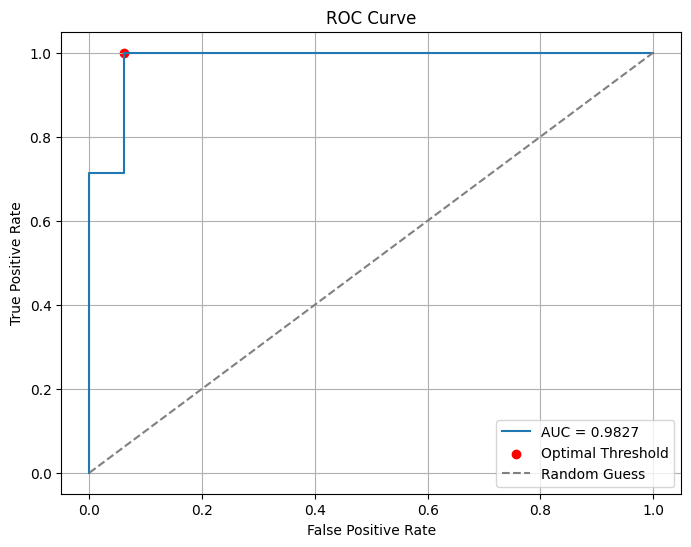

-- FRED Threshold for Fold 1: 125 --> AUC: 0.9827
---- 4. OBTAIN FRED VALUES FOR CROPPED SET ----
---- 5. FIND PATIENT THRESHOLD ----
['B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-172', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-52', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-68', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-170', 'B22-129', 'B22-129', 'B2

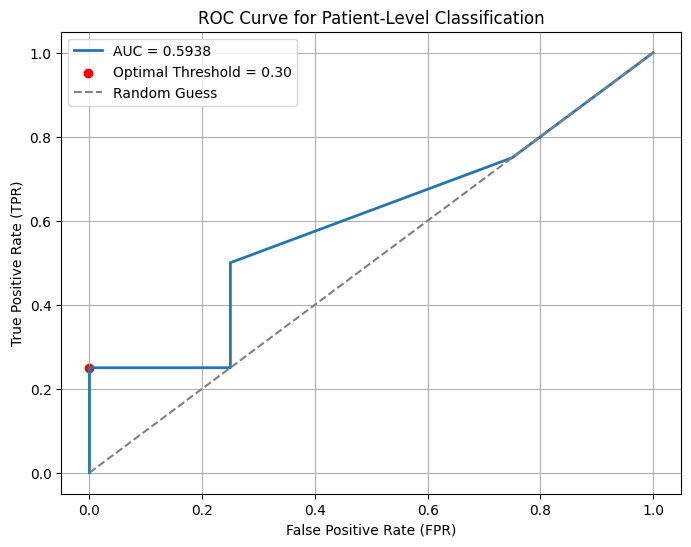

Patient Threshold for Fold 1: 0.3 --> AUC: 0.5938
---- 6. EVALUATE FRED THRESHOLD ----
-------- 6.1 LOAD ANNOTATED DATA ----
-------- 6.2 OBTAIN FRED VALUES ----
-------- 6.3 CLASSIFY IMAGES WITH FRED THRESHOLD ----
-------- 6.4 OBTAIN FRED THRESHOLD METRICS ----
Fold 0 - Evaluation Metrics
Confusion Matrix:
TN: 0, FP: 0, FN: 0, TP: 42
Accuracy: 0.6885
Precision: 1.0000
Recall: 0.6885
F1 Score: 0.8155
---- 7. EVALUATE PATIENT THRESHOLD ----
-------- 7.1 LOAD CROPPED DATA ----
Processing patient 1/2 - image 1/20
Processing patient 2/2 - image 1/20
Resized images: 0/40
-------- 7.2 OBTAIN FRED VALUES FOR CROPPED SET ----
-------- 7.3 OBTAIN PATIENT CLASSIFICATION ----
-------- 7.4 EVALUATE MODEL ----
Fold 0 - Evaluation Metrics
Confusion Matrix:
TN: 0, FP: 0, FN: 0, TP: 1
Accuracy: 0.5000
Precision: 1.0000
Recall: 0.5000
F1 Score: 0.6667


In [67]:
folder_annotated = 'C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Annotated'
folder_cropped = 'C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Cropped'
csv_diagnosis = 'C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/PatientDiagnosis.csv'
excel_HPI = 'C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/HP_WSI-CoordAllAnnotatedPatches.xlsx'

# metrics dict
metrics_th1 = {}
metrics_th2 = {}
patient_thershold = {}
patches_threshold = {}

HPI_excel = pd.read_excel(excel_HPI)
PatDiag_csv = pd.read_csv(csv_diagnosis)

# obtain patient diagnosis labels
pat_diag_lab = {}
for pat_id in patient_list:
    val = PatDiag_csv[PatDiag_csv['CODI'] == pat_id]['DENSITAT'].values[0]
    if val == 'NEGATIVA':
        pat_diag_lab[pat_id] = -1
    else:
        pat_diag_lab[pat_id] = 1

# Bucle para realizar K-Folds
for fold_idx, (train_patients, val_patients) in enumerate(folds):
    print("\n--------------------------------------------")
    print(f"Fold {fold_idx + 1}/{len(folds)}")
    
    # ---- 1. Fold Data Split --------------------------------------------
    print('---- 1. LOAD DATA ----')
    ## ANNOTATED DATA
    print('------------- LOADING ANOTATED DATA -------------')
    dataloader_annotated, presence_labels_train, patient_image_list_ann, images_windows_train = create_annotated_dataloader(train_patients, folder_annotated, excel_HPI, 20)  # Debes implementar o usar tu función para cargar datos
    ## CROPPED DATA
    print('------------- LOADING CROPPED DATA -------------')
    dataloader_cropped, patient_density_labels, patient_image_list_crp = create_cropped_dataloader(train_patients, folder_cropped, csv_diagnosis, 20, prints = True)  # Similar al de entrenamiento, pero con pacientes de validación    
    pat_diag_lab_train = [pat_diag_lab[pat] for pat in train_patients]
    # --------------------------------------------------------------------
    
    # ----- 2. Obtaining FRED values for training set --------------------
    print('---- 2. OBTAIN FRED VALUES ----')
    fred_values_train = get_fred(model, dataloader_annotated, 'cpu')
    # --------------------------------------------------------------------

    # ----- 3. Finding FRED threshold ------------------------------------
    print('---- 3. FIND FRED THRESHOLD ----')
    optimal_threshold_fred, auc, fpr, tpr, roc_thresholds = find_FRED_threshold(fred_values_train, presence_labels_train, visualize=True)
    print(f"-- FRED Threshold for Fold {fold_idx + 1}: {optimal_threshold_fred} --> AUC: {auc:.4f}")
    # --------------------------------------------------------------------

    # ----- 4. Calculating FRED for Cropped set using the model and calculated threshold ----
    print('---- 4. OBTAIN FRED VALUES FOR CROPPED SET ----')
    fred_values_cropped = get_fred(model, dataloader_cropped, 'cpu')
    # ---------------------------------------------------------------------------------------

    # ----- 5. Finding PATIENT threshold ----------------------------------------------------
    print('---- 5. FIND PATIENT THRESHOLD ----')
    print(patient_image_list_crp)
    patient_threshold, auc = find_PATIENT_threshold(fred_values_cropped, patient_image_list_crp, pat_diag_lab_train, optimal_threshold_fred, visualize=True)
    print(f"Patient Threshold for Fold {fold_idx + 1}: {patient_threshold} --> AUC: {auc:.4f}")

    # save thersholds
    patient_thershold[fold_idx] = patient_threshold
    patches_threshold[fold_idx] = optimal_threshold_fred
    # ---------------------------------------------------------------------------------------

    # ---- 6. Evaluating FRED THRESHOLD -------------------------------------
    print('---- 6. EVALUATE FRED THRESHOLD ----')

    # ----- 6.1 Load Data --------------------------------------------------------------
    print('-------- 6.1 LOAD ANNOTATED DATA ----')
    dataloader_annotated_val, presence_labels_val, patient_image_list_val, images_windows_val = create_annotated_dataloader(val_patients, folder_annotated, excel_HPI, -1)  # Debes implementar o usar tu función para cargar datos
   
    # ----- 6.2 Obtaining FRED values for validation set -------------------------------------
    print('-------- 6.2 OBTAIN FRED VALUES ----')
    fred_values_val = get_fred(model, dataloader_annotated_val, 'cpu')

    # ----- 6.3 Classify images using FRED threshold -----------------------------------------
    print('-------- 6.3 CLASSIFY IMAGES WITH FRED THRESHOLD ----')
    img_positive = classify_FRED_threshold(fred_values_val, optimal_threshold_fred)

    # ----- 6.4 Evaluate FRED threshold ------------------------------------------------------
    print('-------- 6.4 OBTAIN FRED THRESHOLD METRICS ----')
    # Convertir a 0 y 1
    img_positive = [1 if x else 0 for x in img_positive]
    presence_labels_val = [1 if x else 0 for x in presence_labels_val]
    metrics_th1 = evaluate_classification(presence_labels_val, img_positive, fold_idx, save_path=None)
    # ---------------------------------------------------------------------------------------

    # ---- 7. Evaluating PATIENT THRESHOLD -------------------------------------
    print('---- 7. EVALUATE PATIENT THRESHOLD ----')

    # ----- 7.1 Load Data --------------------------------------------------------------
    print('-------- 7.1 LOAD CROPPED DATA ----')
    dataloader_cropped_val, patient_density_labels_val, patient_image_list_crp_val = create_cropped_dataloader(val_patients, folder_cropped, csv_diagnosis, 20, prints = True)  # Similar al de entrenamiento, pero con pacientes de validación
    pat_diag_lab_val = [pat_diag_lab[pat] for pat in val_patients]

    # ----- 7.2 Calculating FRED for Cropped set using the model and calculated threshold ----
    print('-------- 7.2 OBTAIN FRED VALUES FOR CROPPED SET ----')
    fred_values_val = get_fred(model, dataloader_cropped_val, 'cpu')

    # ----- 7.3 Calculating FRED for Cropped set using the model and calculated threshold ----
    print('-------- 7.3 OBTAIN PATIENT CLASSIFICATION ----')
    patient_positive = classify_PATIENT_threshold(fred_values_val, val_patients, patient_image_list_crp_val, optimal_threshold_fred, patient_threshold)

    # ----- 7.4 Evaluating the model on the validation set -----------------------------------
    print('-------- 7.4 EVALUATE MODEL ----')
    metrics_th2[fold_idx] = evaluate_classification(pat_diag_lab_val, patient_positive, fold_idx, save_path=None)
    # ---------------------------------------------------------------------------------------
    break

with open('metrics_th1.csv', 'w') as f:
    for key in metrics_th1.keys():
        f.write("%s,%s\n"%(key,metrics_th1[key]))

with open('metrics_th2.csv', 'w') as f:
    for key in metrics_th2.keys():
        f.write("%s,%s\n"%(key,metrics_th2[key]))

In [ ]:
# find rows of Pat_ID ['B22-188' 'B22-52' 'B22-187' 'B22-108' 'B22-129' 'B22-46' 'B22-124' 'B22-170']

df_HPI = pd.read_csv('C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/PatientDiagnosis.csv')

# show rows of Pat_ID ['B22-188' 'B22-52' 'B22-187' 'B22-108' 'B22-129' 'B22-46' 'B22-124' 'B22-170']

print('B22-188',df_HPI[df_HPI['CODI']=='B22-188']['DENSITAT'].values[0])
print('B22-52',df_HPI[df_HPI['CODI']=='B22-52']['DENSITAT'].values[0])
print('B22-187',df_HPI[df_HPI['CODI']=='B22-187']['DENSITAT'].values[0])
print('B22-108',df_HPI[df_HPI['CODI']=='B22-108']['DENSITAT'].values[0])
print('B22-129',df_HPI[df_HPI['CODI']=='B22-129']['DENSITAT'].values[0])
print('B22-46',df_HPI[df_HPI['CODI']=='B22-46']['DENSITAT'].values[0])
print('B22-124',df_HPI[df_HPI['CODI']=='B22-124']['DENSITAT'].values[0])
print('B22-170',df_HPI[df_HPI['CODI']=='B22-170']['DENSITAT'].values[0])

B22-188 NEGATIVA
B22-52 BAIXA
B22-187 NEGATIVA
B22-108 NEGATIVA
B22-129 ALTA
B22-46 ALTA
B22-124 ALTA
B22-170 ALTA
